### Collection and processing of dataset

In [1]:
from survivors.datasets import load_pbc_dataset
X, y, features, categ, sch_nan = load_pbc_dataset()

### Splitting data into train/test samples

In [2]:
from survivors.experiments.grid import generate_sample
# Train contains 80% of source data
# Test contains 20% of source data
a = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(a)

### Tree model

In [3]:
from survivors.tree import CRAID
# craid_tree = CRAID(depth = 5, criterion = "peto", 
#                    min_samples_leaf = 20, signif = 0.05)
# craid_tree = CRAID(criterion = "wilcoxon", cut = True, depth = 10, 
#                    max_features = 1.0, min_samples_leaf = 5, signif = 0.1)

craid_tree = CRAID(criterion = "peto", depth = 2, min_samples_leaf = 30, signif = 0.05)
craid_tree.fit(X_train, y_train)

In [5]:
import os
os.environ['PATH'] = os.environ['PATH'] + ';' + r"C:\ProgramData\Anaconda3\envs\OMSExpmt\Library\bin\graphviz"
craid_tree.visualize(path_dir = "./", mode = "surv", target = "time")

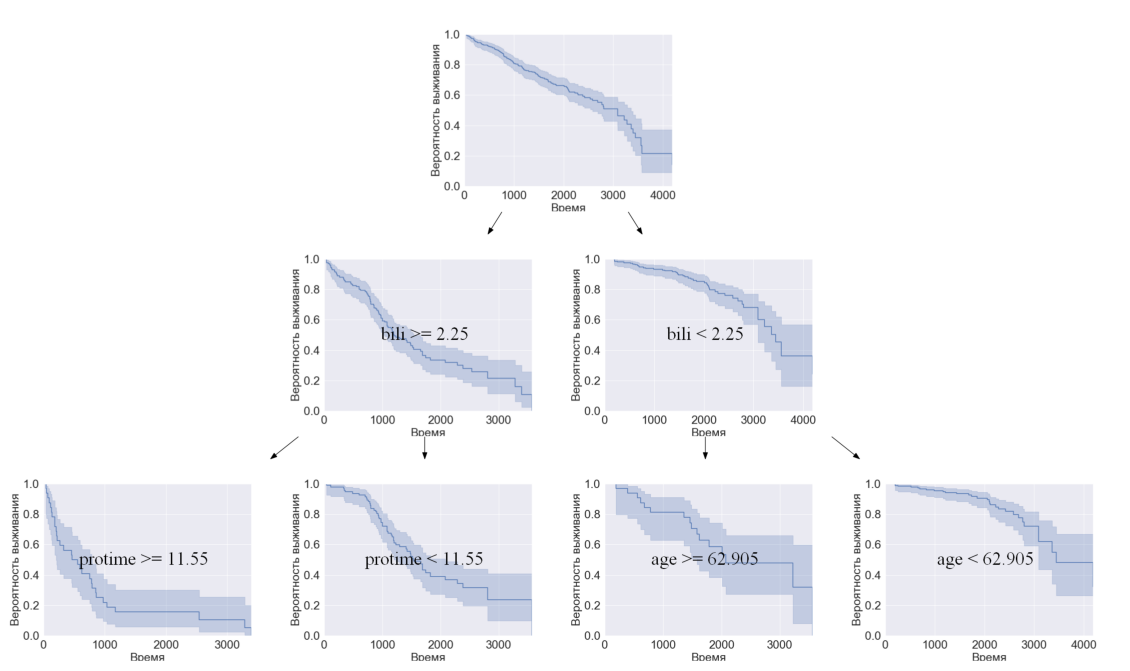

In [15]:
# Print saved picture from : "./" + craid_tree.name + "_.png"
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img = cv2.imread("./" + craid_tree.name + "_.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20, 20))
fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig

In [60]:
pred_time = craid_tree.predict(X_test, target = "time")
pred_prob = craid_tree.predict(X_test, target = "cens")
pred_surv = craid_tree.predict_at_times(X_test, bins = bins, mode = "surv")

In [69]:
i = 20
print("true:", y_test[i])
print("predicted:", pred_prob[i], pred_time[i])

true: (False, 3445.)
predicted: 0.29411764705882354 1840.1764705882354


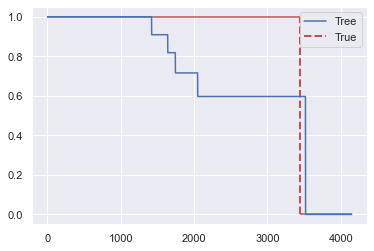

In [70]:
fig, ax = plt.subplots()
ax.plot(pred_surv[i], label = "Tree")
ax.hlines(1.0, 0, y_test[i]["time"], color = 'r')
ax.hlines(0.0, y_test[i]["time"], len(pred_surv[i]), color = 'r')
ax.vlines(y_test[i]["time"], 0, 1, 
              color = 'r', 
              linestyles = ('solid' if y_test[i]["cens"] else 'dashed'),
              linewidth = 2, 
              label = "True")
ax.legend()

### Boosting

In [3]:
from survivors.ensemble import BoostingCRAID

bstr = BoostingCRAID(criterion = "peto", 
                           depth = 5, 
                           min_samples_leaf = 30,
                           n_estimators = 3)
bstr.fit(X_train, y_train)

[0.6541 0.7191 0.7478]
fitted: 3 models.


In [4]:
bstr.bettas

[0.06726457733777294, 0.08173060857576495, 0.048712693796604756]

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

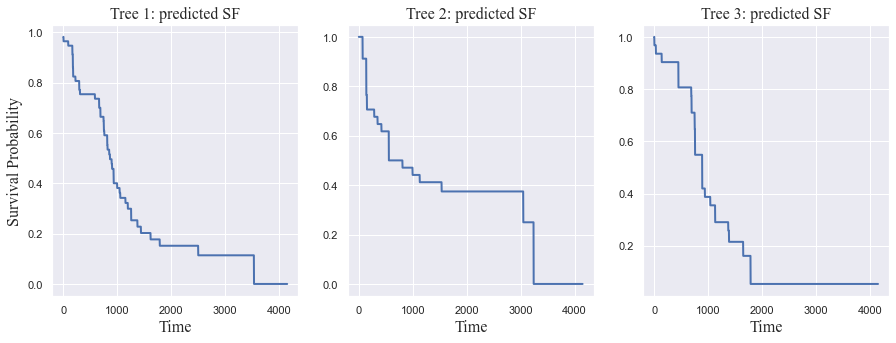

In [20]:
obs_number = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_ylabel("Survival Probability", **axis_font)
for i in range(len(bstr.models)):
    pred_surv = bstr.models[i].predict_at_times(X_test, bins = bins, mode = "surv")
    axs[i].plot(pred_surv[obs_number], label = "Tree")
    axs[i].set_xlabel("Time", **axis_font)
    axs[i].set_title(f"Tree {i+1}: predicted SF", **axis_font)
plt.savefig('SFByModels.png')

Text(0.5, 1.0, 'Boosting: predicted SF')

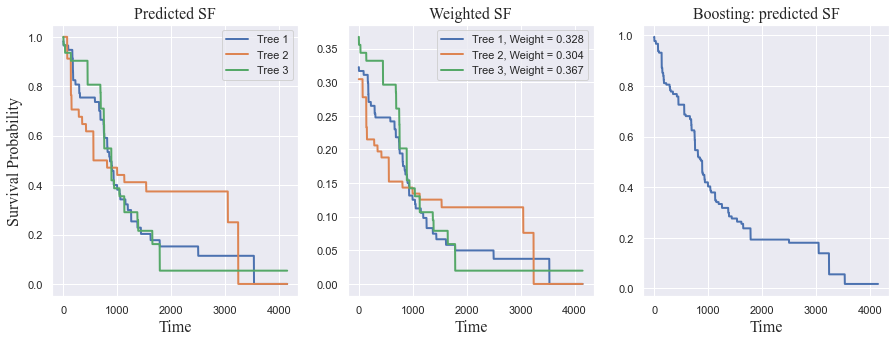

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

inv_wei = -1*np.log(bstr.bettas)
wei = inv_wei/sum(inv_wei)
    
axs[0].set_ylabel("Survival Probability", **axis_font)
for i in range(len(bstr.models)):
    pred_surv = bstr.models[i].predict_at_times(X_test, bins = bins, mode = "surv")
    axs[0].plot(pred_surv[obs_number], label = f"Tree {i+1}")
    axs[0].set_xlabel("Time", **axis_font)
    axs[0].set_title(f"Predicted SF", **axis_font)
    
    axs[1].plot(wei[i]*pred_surv[obs_number], label = f"Tree {i+1}, Weight = {round(wei[i],3)}")
    axs[1].set_xlabel("Time", **axis_font)
    axs[1].set_title(f"Weighted SF", **axis_font)

axs[0].legend()
axs[1].legend()
    
pred_surv = bstr.predict_at_times(X_test, bins = bins, mode = "surv")
axs[2].plot(pred_surv[obs_number])
axs[2].set_xlabel("Time", **axis_font)
axs[2].set_title(f"Boosting: predicted SF", **axis_font)

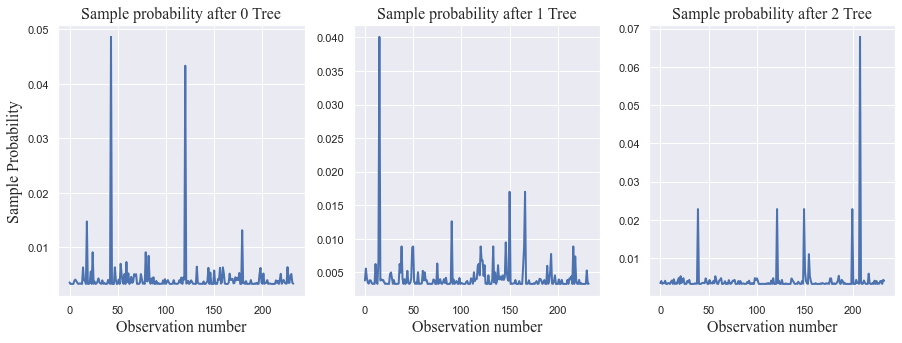

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

wei = np.ones(bstr.X_train.shape[0], dtype = float)
axs[0].set_ylabel("Sample Probability", **axis_font)
for i in range(len(bstr.models)):
#     index_model = bstr.X_train.loc[bstr.X_train.index.difference(bstr.oob[i].index),:]['ind_start']
    axs[i].set_title(f"Sample probability after {i} Tree", **axis_font)
    axs[i].plot(bstr.l_weights[i]/sum(bstr.l_weights[i]))
    axs[i].set_xlabel("Observation number", **axis_font)

In [71]:
bstr.l_weights[2].shape

(233,)

[0.6541]
fitted: 1 models.
[0.6541 0.7191]
fitted: 2 models.
[0.6541 0.7191 0.7478]
fitted: 3 models.


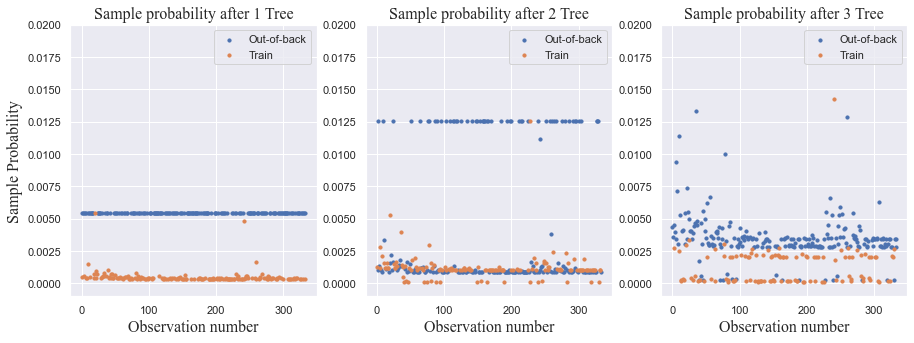

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

weights = np.ones(bstr.X_train.shape[0], dtype = int)
weights = weights/sum(weights)

numbers = np.arange(bstr.X_train.shape[0], dtype = int)
axs[0].set_ylabel("Sample Probability", **axis_font)
for i in range(1, 4):
    bstr = BoostingCRAID(criterion = "peto", 
                               depth = 5, 
                               min_samples_leaf = 30,
                               n_estimators = i)
    bstr.fit(X_train, y_train)
    train_index = bstr.X_train.loc[bstr.X_train.index.difference(bstr.oob[i-1]['ind_start']),:]['ind_start']
    oob_index = bstr.oob[i-1]['ind_start']
    axs[i-1].set_title(f"Sample probability after {i} Tree", **axis_font)
    weights = bstr.weights/sum(bstr.weights)
    axs[i-1].scatter(numbers[oob_index], weights[oob_index], 10, label = "Out-of-back")
    axs[i-1].scatter(numbers[train_index], weights[train_index], 10, label = "Train")
    axs[i-1].set_xlabel("Observation number", **axis_font)
    axs[i-1].legend()
    axs[i-1].set_ylim([-0.001, 0.02])

[0.6541]
fitted: 1 models.
(169,)
[0.6541 0.7191]
fitted: 2 models.
(199,)
[0.6541 0.7191 0.7478]
fitted: 3 models.
(220,)


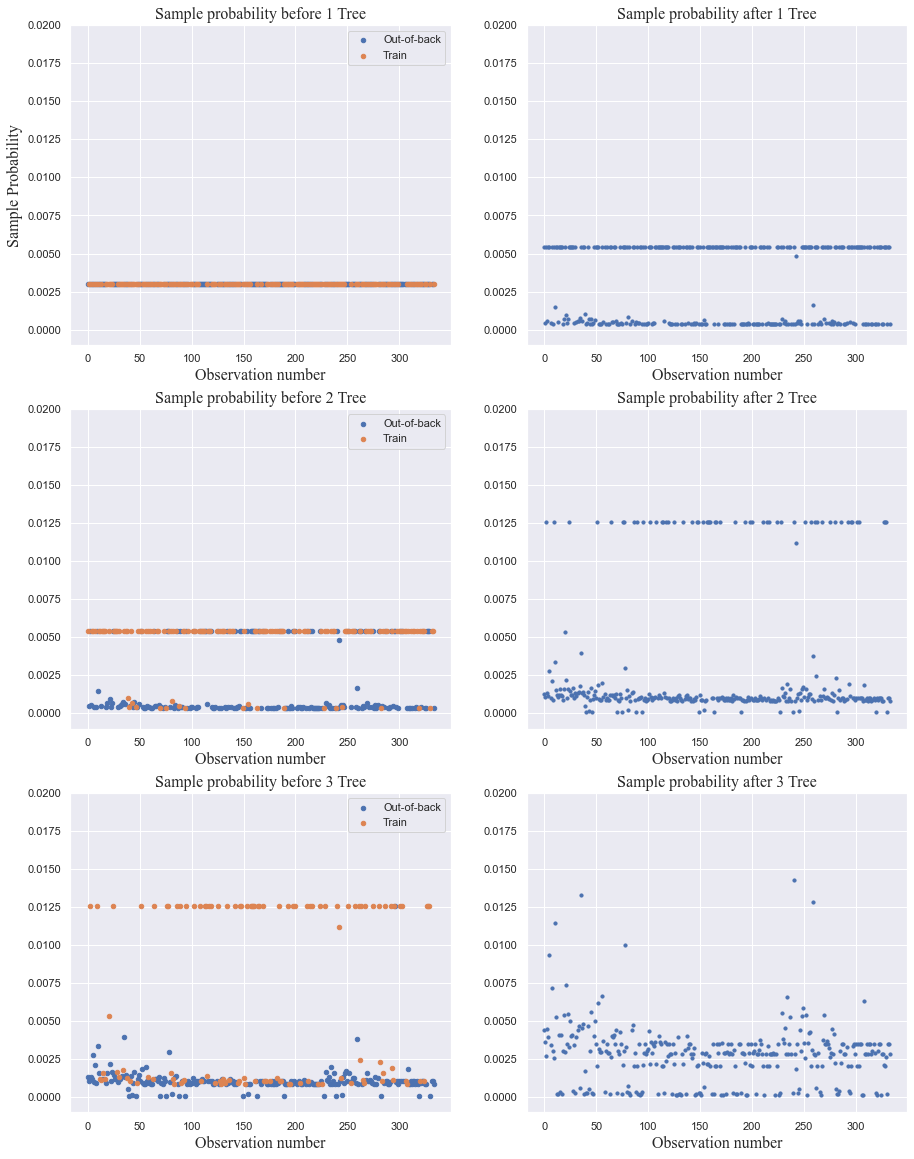

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

weights = np.ones(bstr.X_train.shape[0], dtype = int)
weights = weights/sum(weights)

numbers = np.arange(bstr.X_train.shape[0], dtype = int)
axs[0][0].set_ylabel("Sample Probability", **axis_font)
for i in range(1, 4):
    bstr = BoostingCRAID(criterion = "peto", 
                               depth = 5, 
                               min_samples_leaf = 30,
                               n_estimators = i)
    bstr.fit(X_train, y_train)
    train_index = bstr.X_train.loc[bstr.X_train.index.difference(bstr.oob[i-1]['ind_start']),:]['ind_start']
    oob_index = bstr.oob[i-1]['ind_start']
    print(oob_index.shape)
    axs[i-1][0].set_title(f"Sample probability before {i} Tree", **axis_font)
    axs[i-1][0].scatter(numbers[oob_index], weights[oob_index], 20, label = "Out-of-back")
    axs[i-1][0].scatter(numbers[train_index], weights[train_index], 20, label = "Train")
    weights = bstr.weights/sum(bstr.weights)
    axs[i-1][1].set_title(f"Sample probability after {i} Tree", **axis_font)
    axs[i-1][1].scatter(numbers, weights, 10)
    axs[i-1][0].set_xlabel("Observation number", **axis_font)
    axs[i-1][0].legend()
    axs[i-1][0].set_ylim([-0.001, 0.02])
    axs[i-1][1].set_xlabel("Observation number", **axis_font)
    axs[i-1][1].set_ylim([-0.001, 0.02])

[0.6541]
fitted: 1 models.
(169,)
[0.6541 0.6903]
fitted: 2 models.
(209,)
[0.6541 0.6903 0.7099]
fitted: 3 models.
(262,)


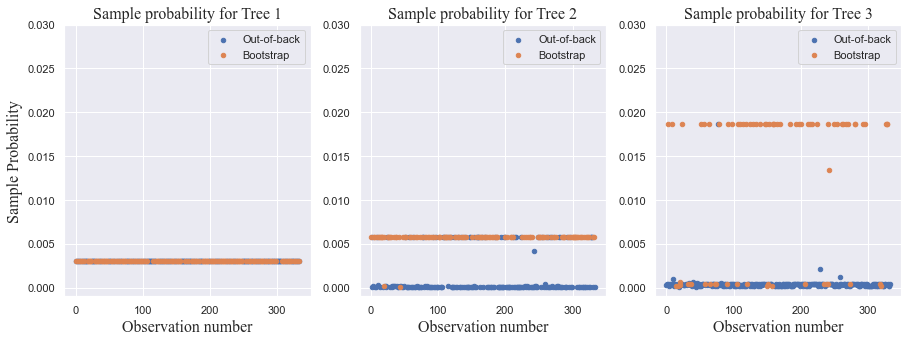

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

weights = np.ones(bstr.X_train.shape[0], dtype = int)
weights = weights/sum(weights)

numbers = np.arange(bstr.X_train.shape[0], dtype = int)
axs[0].set_ylabel("Sample Probability", **axis_font)
for i in range(1, 4):
    bstr = BoostingCRAID(criterion = "peto", 
                         depth = 5, 
                         min_samples_leaf = 30,
                         n_estimators = i,
                         mode_wei = "square")
    bstr.fit(X_train, y_train)
    train_index = bstr.X_train.loc[bstr.X_train.index.difference(bstr.oob[i-1]['ind_start']),:]['ind_start']
    oob_index = bstr.oob[i-1]['ind_start']
    print(oob_index.shape)
    axs[i-1].set_title(f"Sample probability for Tree {i}", **axis_font)
    axs[i-1].scatter(numbers[oob_index], weights[oob_index], 20, label = "Out-of-back")
    axs[i-1].scatter(numbers[train_index], weights[train_index], 20, label = "Bootstrap")
    weights = bstr.weights/sum(bstr.weights)
    axs[i-1].set_xlabel("Observation number", **axis_font)
    axs[i-1].legend()
    axs[i-1].set_ylim([-0.001, 0.03])

In [61]:
def loss_func(var, mode = 'linear'):
    D = var.max()
    if mode == 'linear':
        return var/D
    elif mode == 'square':
        return (var/D)**2
    elif mode == 'exp':
        return 1.0 - np.exp(-var/D)
    return None

def count_weight(losses, mode = 'linear'):
    li = loss_func(losses, mode = mode)
    l_mean = li.mean() #(li * pred_wei).sum()/pred_wei.sum()
    betta = l_mean/(1.0 - l_mean)
    new_wei = betta ** (1 - li)
    return new_wei, betta

In [99]:
import survivors.constants as cnt
import survivors.metrics as metr
from survivors.tree import CRAID

weights = np.ones(bstr.X_train.shape[0], dtype = float)
weights = weights/sum(weights)
x_sub = bstr.X_train.sample(n = bstr.size_sample, weights = weights, 
                       replace=bstr.bootstrap, random_state=1)
x_oob = bstr.X_train.loc[bstr.X_train.index.difference(x_sub.index),:]

x_sub = x_sub.reset_index(drop=True)
X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)

model = CRAID(features = bstr.features, random_state = 1, **bstr.tree_kwargs)
model.fit(X_sub_tr, y_sub_tr)

pred_surv = model.predict_at_times(bstr.X_train, bins = bstr.bins, mode = "surv")
losses = metr.ibs(bstr.y_train, bstr.y_train, pred_surv, bstr.bins, axis = 0)
wei, betta = count_weight(losses, mode = bstr.mode_wei)

Text(0.5, 1.0, 'Weighted sample probability')

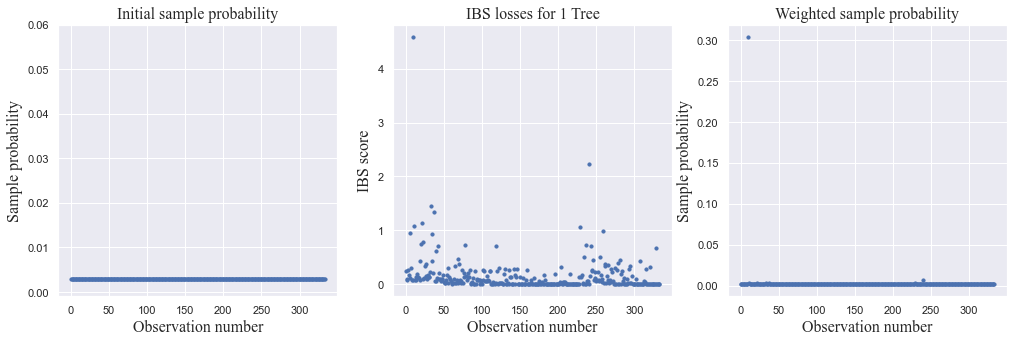

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

numbers = np.arange(bstr.X_train.shape[0], dtype = float)

axs[0].set_ylim([-0.001, 0.06])
axs[0].scatter(numbers, weights, s = 10)
axs[0].set_xlabel("Observation number", **axis_font)
axs[0].set_ylabel("Sample probability", **axis_font)
axs[0].set_title(f"Initial sample probability", **axis_font)

axs[1].scatter(numbers, losses, s = 10)
axs[1].set_xlabel("Observation number", **axis_font)
axs[1].set_ylabel("IBS score", **axis_font)
axs[1].set_title(f"IBS losses for 1 Tree", **axis_font)

axs[2].scatter(numbers, wei/sum(wei), s = 10)
axs[2].set_xlabel("Observation number", **axis_font)
axs[2].set_ylabel("Sample probability", **axis_font)
axs[2].set_title(f"Weighted sample probability", **axis_font)

In [16]:
# Metrics iauc, ibs ...